## Distribution of mean reconstructed energy per layer (violin plots)

In [2]:
import sys
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist

sys.path.append("..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId

from longitudinalProfile.violin import makeViolinBeamEnergy

In [3]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v41'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data"}

In [4]:
h = (histStore
        .get(HistogramId("Clus3DClusteredEnergyPerLayer", clueParams, "data"))
        .getHistogram(HistogramKind.PROFILE)
    [{
        "mainOrAllTracksters" : hist.loc("mainTrackster"),
        # Project on clus3D_size
        "beamEnergy" : hist.loc(20)
    }]
    .project("clus2D_layer")
)
h

Hist(Integer(0, 30, name='clus2D_layer', label='Layer number'), storage=Mean()) # Sum: Mean(count=544124, value=0.629837, variance=0.539294)

In [5]:
def getHist(layer):
    return (histStore
        .get(HistogramId("Clus3DClusteredEnergyPerLayer", clueParams, "data"))
        .getHistogram(HistogramKind.PROFILE)
    [{
        "mainOrAllTracksters" : hist.loc("mainTrackster"),
        # Project on clus3D_size
        "beamEnergy" : hist.loc(20)
    }]
    .project("clus2D_layer")
    )

In [14]:
def makeViolinBeamEnergy_wrapper(datatype:str, beamEnergies=beamEnergies):
    hists = {beamEnergy : histStore
        .get(HistogramId("Clus3DClusteredEnergyPerLayer", clueParams, datatype))
        .getHistogram(HistogramKind.PROFILE)
        [{
            "mainOrAllTracksters" : hist.loc("mainTrackster"),
            # Project on clus3D_size
            "beamEnergy" : hist.loc(beamEnergy)
        }]
        .project("clus2D_layer")
        for beamEnergy in beamEnergies
    }
    makeViolinBeamEnergy(hists, datatype)
    plt.xlim(0, 29)
    

## Data/sim separate
Plots for each beam energy, and each layer, the mean (over all events) of the 3D clustered energy in the layer
(main trackster only)

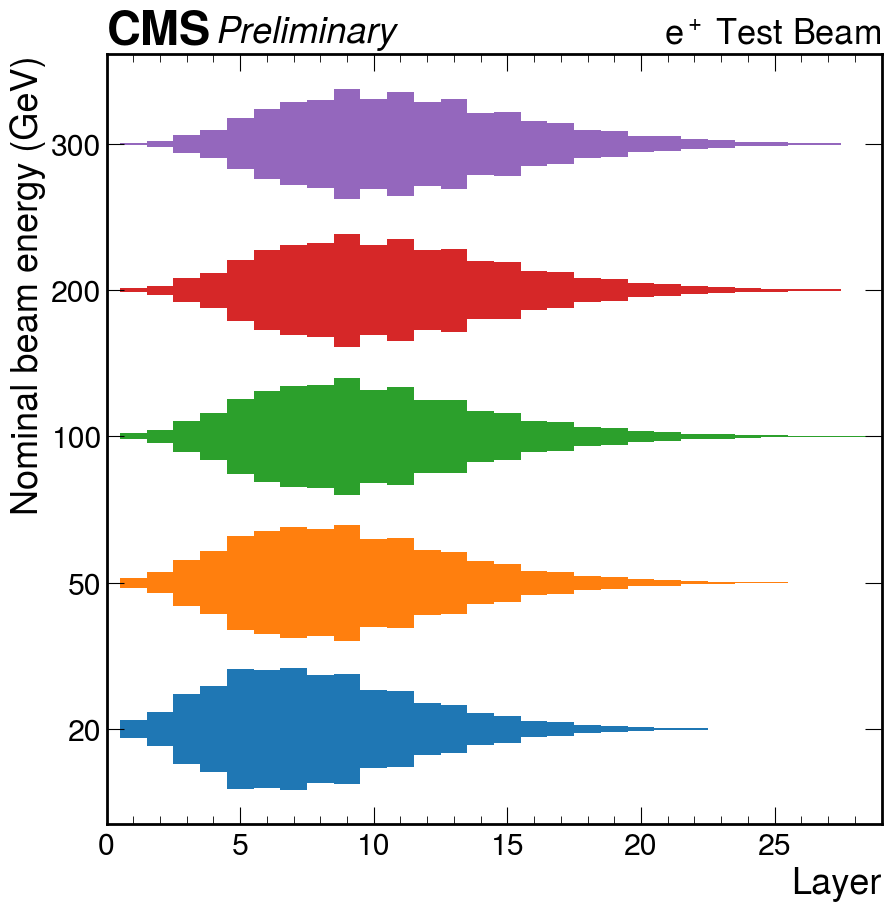

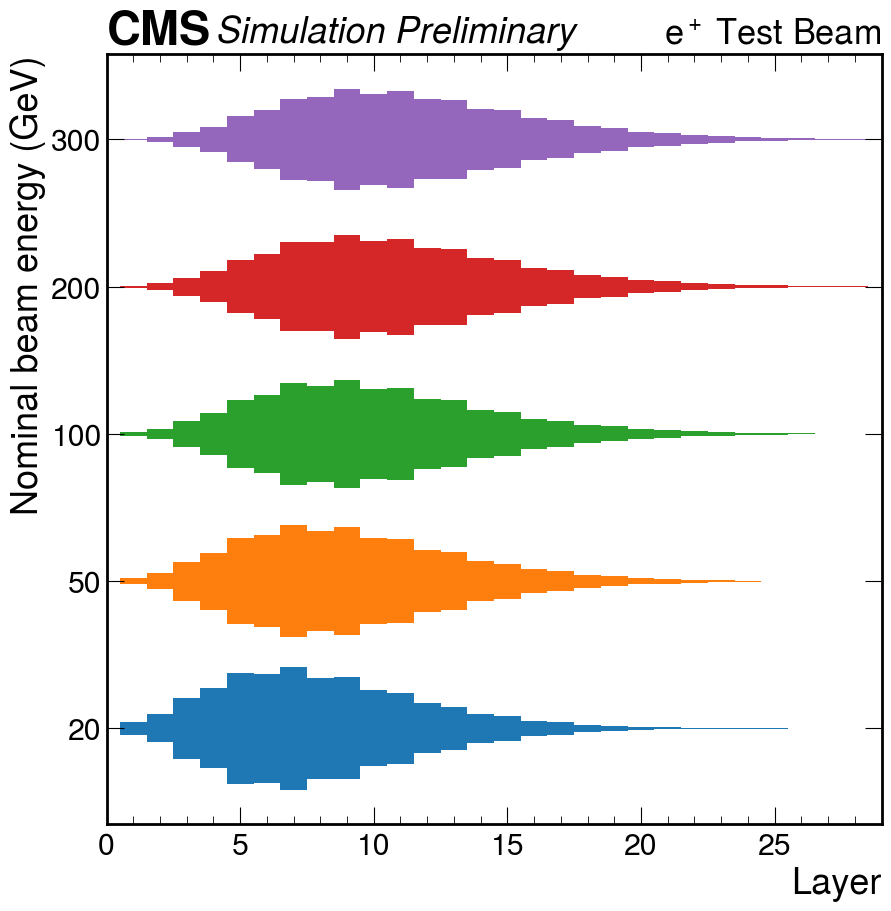

In [16]:
beamEnergiesToPlot = [20, 50, 100, 200, 300]
makeViolinBeamEnergy_wrapper("data", beamEnergies=beamEnergiesToPlot)
plt.savefig("plots/violin-data.pdf", bbox_inches="tight")
makeViolinBeamEnergy_wrapper("sim_proton_v46_patchMIP", beamEnergies=beamEnergiesToPlot)
plt.savefig("plots/violin-sim.pdf", bbox_inches="tight")

## Data/sim overlaid

In [8]:
def makeViolinStep(beamEnergies:int, datatypes:list[str]):
    """ Plots for each beam energy, and each layer, the mean (over all events) of the 3D clustered energy in the layer
    (main trackster only)
    """
    hists_tuples = {beamEnergy : [histStore
        .get(HistogramId("Clus3DClusteredEnergyPerLayer", clueParams, datatype))
        .getHistogram(HistogramKind.PROFILE)
        [{
            "mainOrAllTracksters" : hist.loc("mainTrackster"),
            # Project on clus3D_size
            "beamEnergy" : hist.loc(beamEnergy)
        }]
        .project("clus2D_layer")
        for datatype in datatypes
    ] for beamEnergy in beamEnergies}
    
    colors_cycle = itertools.cycle(matplotlib.colors.TABLEAU_COLORS)
    colors = [next(colors_cycle) for datatype in datatypes]
    fig, ax = plt.subplots()
    max_height = max((np.max(h.density()) for hists_tuple in hists_tuples.values() for h in hists_tuple))*1.2
    y_locations = np.arange(0, max_height*len(hists_tuples), max_height)
    firstLegend = True
    for hists_tuple, y_location in zip(hists_tuples.values(), y_locations):
        for h, datatype, color in zip(hists_tuple, datatypes, colors):
            label = datatype if firstLegend else f"_{datatype}"
            ax.step(x=h.axes[0].edges+0.5, y=np.append(h.density()/2 + y_location, [y_location]), where="pre", label=label, color=color)
            #Ignore legend for second step
            ax.step(x=h.axes[0].edges+0.5, y=np.append(-h.density()/2 + y_location, [y_location]), where="pre", label=f"_{datatype}", color=color)
        firstLegend = False
    ax.set_xlabel("Layer")
    ax.set_ylabel("Beam energy (GeV)")
    #ax.set_ylim(bottom=y_locations[0]-max_height/2*1.3)
    ax.set_yticks(y_locations, beamEnergies)
    ax.yaxis.set_minor_locator(matplotlib.ticker.NullLocator())
    ax.legend()

    if "data" in datatypes:
        hep.cms.text("Preliminary")
    else:
        hep.cms.text("Simulation Preliminary")
    hep.cms.lumitext("$e^+$ test beam")
    

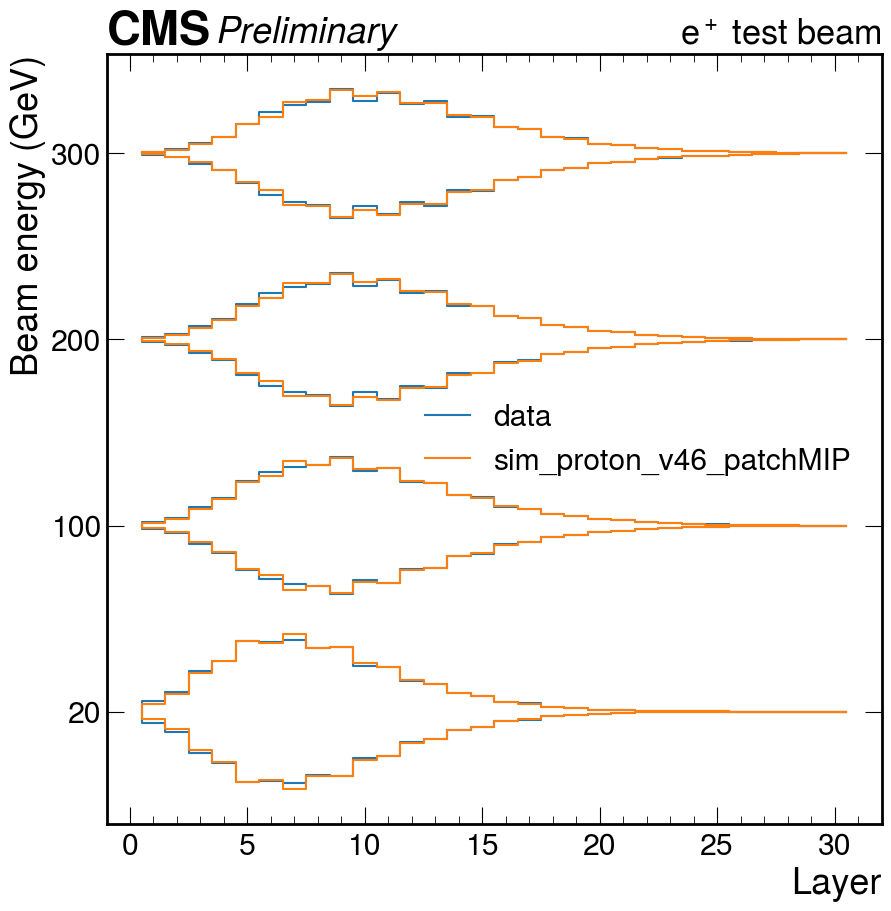

In [9]:
makeViolinStep([20, 100, 200, 300], ["data", "sim_proton_v46_patchMIP"])